#오디오 처리

1.소리는 진동으로 인한 공기의 압축으로 생성된다,

2.압축이 얼마나 되었느냐에 따라 진동하며, 공간이나 매질을 전파해 나가는 현상인 Wave(파동)으로 표현

3.파동으로 얻을 수 있는 정보

3-1.위상(Phase)

3-2.진폭(Amplitude) ->파형의 높낮이

3-3.주파수(Frequency)

오디어 라이브러리
librosa는 각종 음성 처리에 유용한 라이브러리

colab에서는 torchaudio는 별도 설치가 필요함

torchaudio를 이용해 음성 데이터를 이용

In [1]:
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white') #matplotlib의 스타일 지정

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd

#오디오 데이터 특징

1.pytorch의 torchaudio를 사용해 내장 데이터셋을 가져온다.

2.데이터가 크기 때문에 시간이 많이 소요된다.

In [6]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./",url="train-clean-100",download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./",url="test-clean",download=True)

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

불러온 데이터 확인

첫번째 줄에서는 소리 데이터 확인 가능

두번째 줄에서는 해당 데이터의 sampling rate 확인 가능

In [8]:
test_dataset[1]

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

불러온 데이터의 형상을 확인한다.

데이터 길이만으로 음성이 몇초에 해당하는지(duration)를 알 수 없다.

In [7]:
test_dataset[1][0].shape

torch.Size([1, 52400])

#샘플링(Sampling)

sampling

음성을 처리하기 위해 아날로그 정보를 잘게 쪼개 이산적인 디지털 정보로 표현해야한다.

이때 무한히 쪼개서 저장할 수는 없으므로, 기준을 세워서 아날로그 정보를 쪼개 대표값을 사용한다, 이를 샘플링이라 한다.

주로 사용할 때 시간을 기준으로 아날로그 정보를 쪼개는 Time Domain 방식을 사용한다.

Sampling rate

sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지를 결정한다.

잘게 쪼갤수록 정보 손실이 줄지만, 데이터 크기가 늘어난다.

Sampling theorem

sampling rate가 최대 frequency보다 2배 커져야 함을 의미

일반적으로 sampling은 인간이 청각 영역에 맞게 형성

Audio CD: 44.1kHz(44100 sample/second) -> 1초당 44100 샘플을 갖는다. aka.고음질 이라는 기준치
Speech communication : 8Khz(8000 sample/second) ->1초당 8000샘플을 갖는다 예전 전화선에 했을 때 옛날 전화  aka.저음질

음성의 duration은 데이터의 길이와 sampling rate를 나누어 확인 가능

In [13]:
audio_data = test_dataset[1][0][0] # ensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011] 이 값
sr = test_dataset[1][1] #샘플링 rate를 가져오는거 16000

print(audio_data, sr) 
print('length:',len(audio_data)) #전체 오디오 데이터의 길이
print('duration:',len(audio_data) / sr) #duration 공식 -> audio_data / sr  -> 초 단위

ipd.Audio(audio_data, rate= sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


#Resampling

Resampling은 sampling data의 sampling rate를 조정해 다시 sampling하는 것

이때 일반적으로 보간(interpolation)을 할때는 low-pass filter를 사용 (높은 주파수 영역들 보간하기 위해)

librosa.resample을 사용하면 편리하게 resampling 가능

현재 데이터는 torch tensor, librosa는 numpy 배열을 받아들이기 때문에 변환이 필요

sampling rate를 절반으로 줄여, 길이도 절반으로 준 것을 확인할 수 있음

In [18]:
audio_np = audio_data.numpy()
y_8k = librosa.resample(audio_np, sr, 8000)

print(len(audio_np),len(y_8k))
ipd.Audio(y_8k, rate = 8000) #전화 소리랑 비슷함

52400 26200


In [16]:
audio_np = audio_data.numpy()
y_8k = librosa.resample(audio_np, sr, 4000)

print(len(audio_np),len(y_8k))
ipd.Audio(y_8k, rate = 4000) #무전기 소리 급

52400 13100


# Normalization & Quantization

데이터간 음량이 제각가인 경우 normalizaion을 하여 amplitude를 [-1,1] 범위로 조정

여기서는 가장 간단한 방법인 데이터의 최대값으로 나눠주는 방법을 사용한다.

Normalization

In [19]:
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate = sr)

Quantization

In [26]:
bit = 8
max_value = 2 ** (bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate =sr)

결과로는 노이즈가 심해졌다.

#Mu-Law Encoding

사람의 귀는 작은소리의 차이는 잘 잡아내는데 소리가 커질수록, 그 차이를 잘 느끼지 못한다.

이러한 특성을wave값을 표현하는데 반영해 작은 값에는 높은 분별력을,큰 값끼리는 낮은 분별력을 갖도록 함

In [27]:
def mu_law(x,mu=255):
  return np.sign(x)*np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

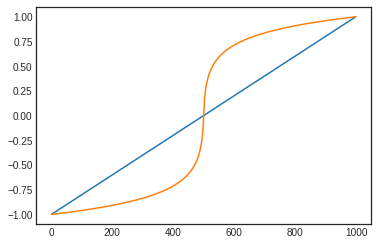

In [28]:
x = np.linspace(-1,1,1000)
x_mu = mu_law(x)

plt.figure(figsize=[6,4])
plt.plot(x)
plt.plot(x_mu)
plt.show()